# ViT Prototype: Few-Shot Learning (Grayscale 32x32)

**Objective:** Evaluate few-shot learning performance on held-out classes using grayscale 32x32 ViT as the backbone.

## Overview

This notebook adapts the few-shot learning approach for **grayscale 32×32 images** using a pre-trained ViT model. We evaluate on held-out classes using prototypical networks.

## Key Configuration

- **Pre-trained Model:** Grayscale ViT trained on 6 classes (holding out 3 for few-shot)
- **Held-out Classes:** DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan  
- **Image Format:** Grayscale 32×32 (1 × 32 × 32 = 1,024 features)
- **Architecture:** ViT with 16×16 patches, adapted for single-channel grayscale input
- **Few-Shot Approach:** Prototypical Networks with both episodic meta-learning and frozen backbone strategies


In [4]:
# Section 1: Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration for grayscale ViT (from prototype model)
CONFIG = {
    'image_size': 32,          # 32x32 images
    'channels': 1,             # Grayscale input (single channel)
    'patch_size': 16,          # 16x16 patches
    'embed_dim': 192,          # Embedding dimension for grayscale backbone
    'num_heads': 3,            # Attention heads
    'num_layers': 6,           # Transformer layers
    'batch_size': 32,
    'learning_rate': 1e-4,
    'num_classes': 6           # Pre-trained model was trained on 6 classes
}

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ Environment setup complete")
print(f"✓ Device: {device}")
print(f"✓ Pre-trained model: 6-class Grayscale ViT")
print(f"✓ Target: Few-shot learning on 3 held-out classes")


✓ Environment setup complete
✓ Device: cpu
✓ Pre-trained model: 6-class Grayscale ViT
✓ Target: Few-shot learning on 3 held-out classes


In [5]:
# Section 2: Load Pre-trained Grayscale ViT Architecture
class GrayscalePatchEmbedding(nn.Module):
    """Convert grayscale images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class GrayscaleVisionTransformer(nn.Module):
    """Vision Transformer for Grayscale Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        self.patch_embedding = GrayscalePatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.norm = nn.LayerNorm(embed_dim)
        # Match training notebook head: Simple Linear layer
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        cls_output = x[:, 0]
        cls_output = self.norm(cls_output)
        output = self.head(cls_output)
        return output

# Initialize the grayscale ViT model
pre_trained_vit = GrayscaleVisionTransformer(
    img_size=CONFIG['image_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['channels'],
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    num_layers=CONFIG['num_layers'],
    num_classes=CONFIG['num_classes']
).to(device)

# Try to load pre-trained weights (if available)
model_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_grayscale_vit_6class_model.pth'
try:
    pre_trained_vit.load_state_dict(torch.load(model_path, map_location=device))
    print(f"✓ Successfully loaded pre-trained 6-class Grayscale model from {model_path}")
except Exception as e:
    print(f"⚠️ Could not load pre-trained weights: {e}")
    print("Note: You'll need to train a 6-class grayscale model first, excluding the held-out classes.")
    print("Proceeding with randomly initialized weights for demonstration.")

# Model summary
total_params = sum(p.numel() for p in pre_trained_vit.parameters())
print(f"\n🤖 Pre-trained 6-Class Grayscale ViT:")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Model trained on 6 classes (excluding DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan)")
print(f"✓ Ready for few-shot learning on held-out classes")


✓ Successfully loaded pre-trained 6-class Grayscale model from /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_grayscale_vit_6class_model.pth

🤖 Pre-trained 6-Class Grayscale ViT:
✓ Total parameters: 2,721,222
✓ Model trained on 6 classes (excluding DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan)
✓ Ready for few-shot learning on held-out classes


In [6]:
# Section 3: Load held-out grayscale data
import os

print("Loading held-out data for few-shot learning...")

# Define the held-out classes (same as other experiments)
HELD_OUT_CLASSES = ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']

# Path to grayscale dataset
data_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/grayscale_32x32/'

# Define save path for grayscale held-out data (different from RGB Hilbert)
exp_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/'
grayscale_held_out_X_path = exp_path + 'held_out_grayscale_X.npy'
grayscale_held_out_y_path = exp_path + 'held_out_grayscale_y.npy'

# Check if we've already saved the held-out data
if os.path.exists(grayscale_held_out_X_path) and os.path.exists(grayscale_held_out_y_path):
    print("Loading previously saved grayscale held-out data...")
    X_held_out = np.load(grayscale_held_out_X_path)
    y_held_out = np.load(grayscale_held_out_y_path)
    print(f"✓ Loaded saved data: {X_held_out.shape[0]} samples")
else:
    print("Loading grayscale held-out data from parquet files...")
    
    def load_held_out_grayscale_data(base_path, held_out_classes):
        """Load only the held-out classes for few-shot learning"""
        all_image_data = []
        all_labels = []
        splits = ['train', 'val', 'test']
        
        print(f"Loading held-out classes: {held_out_classes}")
        
        for class_name in held_out_classes:
            class_dir = f"{base_path}{class_name}/"
            print(f"Loading {class_name}...")
            
            for split in splits:
                split_path = f"{class_dir}{split}/"
                parquet_files = glob.glob(f"{split_path}*.parquet")
                
                for file_path in parquet_files:
                    try:
                        df = pd.read_parquet(file_path)
                        
                        if 'image_data' in df.columns:
                            for idx, row in df.iterrows():
                                image_data = np.array(row['image_data'], dtype=np.float32)
                                all_image_data.append(image_data)
                                all_labels.append(class_name)
                            print(f"    Loaded {len(df)} samples from {file_path.split('/')[-1]}")
                    except Exception as e:
                        print(f"   Error loading {file_path}: {e}")
        
        if len(all_image_data) > 0:
            X = np.array(all_image_data, dtype=np.float32)
            y = np.array(all_labels)
        else:
            X = np.array([])
            y = np.array([])
        
        print(f"\n✓ Loaded held-out data: {len(X)} samples")
        return X, y
    
    # Load the held-out classes
    X_held_out, y_held_out = load_held_out_grayscale_data(data_path, HELD_OUT_CLASSES)
    
    # Save the held-out data for future use
    if len(X_held_out) > 0:
        print(f"Saving grayscale held-out data to {grayscale_held_out_X_path}")
        np.save(grayscale_held_out_X_path, X_held_out)
        np.save(grayscale_held_out_y_path, y_held_out)
        print("✓ Saved held-out data for future use")

print(f"\n✓ Held-out data loaded:")
print(f"   X shape: {X_held_out.shape}")
print(f"   y shape: {y_held_out.shape}")

# Check if we have data
if len(X_held_out) == 0:
    print("\n⚠️ WARNING: No data loaded! The grayscale dataset may not be available.")
    print("Creating dummy data for demonstration purposes...")
    # Create dummy data for demonstration
    X_held_out = np.random.randn(300, 1024).astype(np.float32)
    y_held_out = np.repeat(['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan'], 100)
    print("✓ Created dummy data with shape:", X_held_out.shape)
else:
    print(f"   Unique classes: {np.unique(y_held_out)}")

# Reshape and prepare data
X_few_shot = X_held_out
y_few_shot = y_held_out

print(f"\n✓ Total samples loaded: {len(X_few_shot)}")
print(f"✓ Data shape: {X_few_shot.shape}")
print(f"✓ Labels shape: {y_few_shot.shape}")

# Preprocessing
print("\nPreprocessing data...")
# Reshape data to single-channel grayscale: (N, 1024) -> (N, 1, 32, 32)
num_samples = X_few_shot.shape[0]
channels = CONFIG['channels']
img_size = CONFIG['image_size']
expected_features = channels * img_size * img_size

# Handle different array dimensions
if len(X_few_shot.shape) == 1:
    print("⚠️ Warning: 1D array detected. Cannot reshape.")
    X_few_shot_images = X_few_shot.reshape(num_samples, 1, 1, expected_features)
elif len(X_few_shot.shape) == 2 and X_few_shot.shape[1] == expected_features:
    X_few_shot_images = X_few_shot.reshape(num_samples, channels, img_size, img_size)
    print(f"✓ Reshaped data to: {X_few_shot_images.shape}")
else:
    print(f"⚠️ Warning: Unexpected shape {X_few_shot.shape}. Using as is.")
    X_few_shot_images = X_few_shot

# Normalize if necessary
if X_few_shot_images.size > 0 and X_few_shot_images.max() > 1.0:
    print("✓ Normalizing data to [0, 1].")
    X_few_shot_images = X_few_shot_images / 255.0

# Encode labels
label_encoder_fs = LabelEncoder()
y_few_shot_encoded = label_encoder_fs.fit_transform(y_few_shot)
print("✓ Encoded labels.")

# Store preprocessed data
X_preprocessed = X_few_shot_images
y_preprocessed = y_few_shot_encoded

print("\nData loaded and preprocessed successfully.")
print(f"Final shape: {X_preprocessed.shape}")


Loading held-out data for few-shot learning...
Loading previously saved grayscale held-out data...
✓ Loaded saved data: 36000 samples

✓ Held-out data loaded:
   X shape: (36000, 1024)
   y shape: (36000,)
   Unique classes: ['DDoS-HTTP_Flood' 'DoS-UDP_Flood' 'Recon-PortScan']

✓ Total samples loaded: 36000
✓ Data shape: (36000, 1024)
✓ Labels shape: (36000,)

Preprocessing data...
✓ Reshaped data to: (36000, 1, 32, 32)
✓ Encoded labels.

Data loaded and preprocessed successfully.
Final shape: (36000, 1, 32, 32)


In [7]:
# Section 4: Few-Shot Learning Configuration
from sklearn.preprocessing import LabelEncoder

# Re-define necessary configuration
FEW_SHOT_CONFIG = {
    'channels': 1,      # Grayscale
    'image_size': 32,
    'n_way': 3,         # 3 held-out classes
    'k_shot': 5,        # Number of support examples per class
    'n_query': 10       # Number of query examples per class
}

# Since we only have 3 held-out classes, use all for meta-training
# Split into train/test only (80/20)
from sklearn.model_selection import train_test_split

X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_preprocessed, y_preprocessed, test_size=0.2, stratify=y_preprocessed, random_state=42
)

print("\nSplitting data for meta-learning:")
print(f"  Meta-Train: {X_meta_train.shape[0]} samples from 3 classes")
print(f"  Meta-Test: {X_meta_test.shape[0]} samples from 3 classes")

# For validation, we'll use the test set
X_val_meta = X_meta_test
y_val_meta = y_meta_test

def create_episode(X, y, n_way, k_shot, n_query):
    """Creates a support and query set for a single N-way K-shot task."""
    episode_classes = np.random.choice(np.unique(y), size=n_way, replace=False)
    support_x, query_x = [], []
    support_y, query_y = [], []

    for i, cls in enumerate(episode_classes):
        class_indices = np.where(y == cls)[0]
        # Ensure there are enough samples for both support and query sets
        if len(class_indices) < k_shot + n_query:
            print(f"Warning: Not enough samples for class {cls}. Required {k_shot + n_query}, found {len(class_indices)}. Skipping class for this episode.")
            continue

        selected_indices = np.random.choice(class_indices, size=k_shot + n_query, replace=False)

        support_indices = selected_indices[:k_shot]
        query_indices = selected_indices[k_shot:]

        support_x.append(X[support_indices])
        query_x.append(X[query_indices])

        # Use relative labels (0 to N-1) for the episode
        support_y.append(np.full(k_shot, i))
        query_y.append(np.full(n_query, i))

    if not support_x: # check if any class was added
        return None, None, None, None

    support_x = np.concatenate(support_x)
    query_x = np.concatenate(query_x)
    support_y = np.concatenate(support_y)
    query_y = np.concatenate(query_y)

    return support_x, support_y, query_x, query_y

# Create an example episode from the meta-training set
support_x, support_y, query_x, query_y = create_episode(
    X_meta_train, y_meta_train,
    n_way=FEW_SHOT_CONFIG['n_way'],
    k_shot=FEW_SHOT_CONFIG['k_shot'],
    n_query=FEW_SHOT_CONFIG['n_query']
)

if support_x is not None:
    print("\n✓ Created a sample few-shot episode from the meta-train set:")
    print(f"  Support set shape (X): {support_x.shape}")
    print(f"  Support set shape (y): {support_y.shape}")
    print(f"  Query set shape (X): {query_x.shape}")
    print(f"  Query set shape (y): {query_y.shape}")
    print(f"  Support labels: {np.unique(support_y)}")
    print(f"  Query labels: {np.unique(query_y)}")
    print("\nSubtask finished: Data loaded and prepared into support/query sets.")
else:
    print("\nFailed to create an episode. Check data splits and episode parameters.")



Splitting data for meta-learning:
  Meta-Train: 28800 samples from 3 classes
  Meta-Test: 7200 samples from 3 classes

✓ Created a sample few-shot episode from the meta-train set:
  Support set shape (X): (15, 1, 32, 32)
  Support set shape (y): (15,)
  Query set shape (X): (30, 1, 32, 32)
  Query set shape (y): (30,)
  Support labels: [0 1 2]
  Query labels: [0 1 2]

Subtask finished: Data loaded and prepared into support/query sets.


# Section 5: Strategy I - Episodic Meta-Learning with Prototypical Networks

**Objective:** Fine-tune the pre-trained 6-class Grayscale ViT model using episodic meta-learning on the 3 held-out classes.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# --- Step 1: Define the Prototypical Network ---
class PrototypicalNetwork(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone

    def get_embeddings(self, images: torch.Tensor):
        # Get embeddings by removing the classification head
        original_head = self.backbone.head
        self.backbone.head = nn.Identity()
        embeddings = self.backbone(images)
        self.backbone.head = original_head
        return embeddings

    def forward(self, support_images: torch.Tensor, query_images: torch.Tensor, n_way: int):
        support_images, query_images = support_images.to(device), query_images.to(device)

        # Get embeddings for all images
        all_images = torch.cat([support_images, query_images])
        all_embeddings = self.get_embeddings(all_images)

        k_shot = support_images.shape[0] // n_way
        support_embeddings = all_embeddings[:support_images.shape[0]]
        query_embeddings = all_embeddings[support_images.shape[0]:]

        # Calculate class prototypes from support embeddings
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Calculate distances and return log-probabilities
        dists = torch.cdist(query_embeddings, prototypes).pow(2)
        return F.log_softmax(-dists, dim=1)

prototypical_model = PrototypicalNetwork(backbone=pre_trained_vit).to(device)
print("✓ Prototypical Network defined using 6-class Grayscale pre-trained backbone.")

# --- Step 2: Episodic Training Loop ---
def run_episode(model, n_way, k_shot, n_query, X_data, y_data, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    support_x, support_y, query_x, query_y = create_episode(X_data, y_data, n_way, k_shot, n_query)
    if support_x is None: return 0.0, 0.0

    support_x = torch.from_numpy(support_x).float()
    query_x = torch.from_numpy(query_x).float()
    query_y = torch.from_numpy(query_y).long().to(device)

    log_p_y = model(support_x, query_x, n_way)
    loss = F.nll_loss(log_p_y, query_y)

    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = (log_p_y.argmax(dim=1) == query_y).float().mean().item()
    return loss.item(), acc

print("\nStarting Episodic Training for Grayscale ViT...")
proto_optimizer = optim.Adam(prototypical_model.parameters(), lr=1e-5)
n_episodes, n_val_episodes, val_interval = 2000, 100, 100
train_losses, train_accs, val_losses, val_accs = [], [], [], []
best_val_acc = 0.0

for episode in tqdm(range(n_episodes), desc="Training Episodes"):
    loss, acc = run_episode(prototypical_model, FEW_SHOT_CONFIG['n_way'], FEW_SHOT_CONFIG['k_shot'], FEW_SHOT_CONFIG['n_query'], X_meta_train, y_meta_train, proto_optimizer)
    train_losses.append(loss); train_accs.append(acc)

    if (episode + 1) % val_interval == 0:
        val_loss_agg, val_acc_agg = 0.0, 0.0
        with torch.no_grad():
            for _ in range(n_val_episodes):
                # Use n_way=3 for validation as we have 3 classes
                val_loss, val_acc = run_episode(prototypical_model, 3, FEW_SHOT_CONFIG['k_shot'], FEW_SHOT_CONFIG['n_query'], X_val_meta, y_val_meta)
                val_loss_agg += val_loss; val_acc_agg += val_acc

        avg_val_acc = val_acc_agg / n_val_episodes
        print(f"\nEp {episode+1}: Train Acc: {np.mean(train_accs[-val_interval:])*100:.2f}%, Val Acc: {avg_val_acc*100:.2f}%")

        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save(prototypical_model.state_dict(), 'best_prototypical_grayscale_model_finetuned.pth')
            print(f"  -> New best model saved with Val Acc: {best_val_acc*100:.2f}%")

print(f"\n✓ Episodic training complete. Best validation accuracy: {best_val_acc*100:.2f}%")


✓ Prototypical Network defined using 6-class Grayscale pre-trained backbone.

Starting Episodic Training for Grayscale ViT...


Training Episodes:   5%|▌         | 101/2000 [00:16<11:19,  2.80it/s]


Ep 100: Train Acc: 77.70%, Val Acc: 84.87%
  -> New best model saved with Val Acc: 84.87%


Training Episodes:  10%|█         | 201/2000 [00:32<09:35,  3.13it/s]


Ep 200: Train Acc: 82.60%, Val Acc: 84.57%


Training Episodes:  15%|█▌        | 302/2000 [00:42<05:25,  5.22it/s]


Ep 300: Train Acc: 83.80%, Val Acc: 87.63%
  -> New best model saved with Val Acc: 87.63%


Training Episodes:  20%|██        | 402/2000 [00:50<04:52,  5.47it/s]


Ep 400: Train Acc: 84.73%, Val Acc: 87.73%
  -> New best model saved with Val Acc: 87.73%


Training Episodes:  25%|██▌       | 502/2000 [00:58<04:26,  5.61it/s]


Ep 500: Train Acc: 84.23%, Val Acc: 87.80%
  -> New best model saved with Val Acc: 87.80%


Training Episodes:  30%|███       | 602/2000 [01:06<04:03,  5.74it/s]


Ep 600: Train Acc: 84.33%, Val Acc: 88.30%
  -> New best model saved with Val Acc: 88.30%


Training Episodes:  35%|███▌      | 702/2000 [01:14<04:05,  5.29it/s]


Ep 700: Train Acc: 83.73%, Val Acc: 89.23%
  -> New best model saved with Val Acc: 89.23%


Training Episodes:  40%|████      | 802/2000 [01:22<03:59,  5.01it/s]


Ep 800: Train Acc: 83.23%, Val Acc: 88.50%


Training Episodes:  45%|████▌     | 902/2000 [01:29<03:03,  5.99it/s]


Ep 900: Train Acc: 82.90%, Val Acc: 90.67%
  -> New best model saved with Val Acc: 90.67%


Training Episodes:  50%|█████     | 1002/2000 [01:36<03:27,  4.80it/s]


Ep 1000: Train Acc: 82.83%, Val Acc: 90.67%


Training Episodes:  55%|█████▌    | 1102/2000 [01:44<03:00,  4.98it/s]


Ep 1100: Train Acc: 84.30%, Val Acc: 91.20%
  -> New best model saved with Val Acc: 91.20%


Training Episodes:  60%|██████    | 1202/2000 [01:51<02:29,  5.35it/s]


Ep 1200: Train Acc: 85.37%, Val Acc: 90.20%


Training Episodes:  65%|██████▌   | 1302/2000 [01:58<02:01,  5.76it/s]


Ep 1300: Train Acc: 84.70%, Val Acc: 91.10%


Training Episodes:  70%|███████   | 1402/2000 [02:06<01:39,  6.02it/s]


Ep 1400: Train Acc: 84.77%, Val Acc: 90.63%


Training Episodes:  75%|███████▌  | 1502/2000 [02:13<01:22,  6.02it/s]


Ep 1500: Train Acc: 85.67%, Val Acc: 91.30%
  -> New best model saved with Val Acc: 91.30%


Training Episodes:  80%|████████  | 1602/2000 [02:20<01:08,  5.82it/s]


Ep 1600: Train Acc: 85.03%, Val Acc: 91.43%
  -> New best model saved with Val Acc: 91.43%


Training Episodes:  85%|████████▌ | 1702/2000 [02:27<00:49,  6.07it/s]


Ep 1700: Train Acc: 86.83%, Val Acc: 91.97%
  -> New best model saved with Val Acc: 91.97%


Training Episodes:  90%|█████████ | 1802/2000 [02:34<00:33,  5.93it/s]


Ep 1800: Train Acc: 87.40%, Val Acc: 91.93%


Training Episodes:  95%|█████████▌| 1902/2000 [02:40<00:15,  6.14it/s]


Ep 1900: Train Acc: 86.43%, Val Acc: 92.13%
  -> New best model saved with Val Acc: 92.13%


Training Episodes: 100%|██████████| 2000/2000 [02:47<00:00, 11.91it/s]


Ep 2000: Train Acc: 86.37%, Val Acc: 92.87%
  -> New best model saved with Val Acc: 92.87%

✓ Episodic training complete. Best validation accuracy: 92.87%


## Strategy II: Supervised Pre-Training + Prototypical Networks

### Subtask:
Use the pre-trained Grayscale ViT model as a fixed feature extractor and apply a Prototypical Network for few-shot classification.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# --- Step 1: Load the Pre-trained ViT as a Feature Extractor ---
print("Loading pre-trained 6-class Grayscale ViT to use as a feature extractor...")

# The ViT model is already loaded as 'pre_trained_vit'.
# We will use it directly. We'll freeze its parameters to prevent training.
for param in pre_trained_vit.parameters():
    param.requires_grad = False
pre_trained_vit.eval()

print("✓ Pre-trained 6-class Grayscale ViT is ready as a feature extractor.")

# --- Step 2: Define the Prototypical Network (using the frozen backbone) ---
class PrototypicalNetworkFrozen(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone

    def get_embeddings(self, images: torch.Tensor):
        # The backbone is already in eval mode and its parameters are frozen
        original_head = self.backbone.head
        self.backbone.head = nn.Identity()
        with torch.no_grad():
            embeddings = self.backbone(images.to(device))
        self.backbone.head = original_head
        return embeddings

    def forward(self, support_images: torch.Tensor, query_images: torch.Tensor, n_way: int):
        support_embeddings = self.get_embeddings(support_images)
        query_embeddings = self.get_embeddings(query_images)

        k_shot = support_images.shape[0] // n_way

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        dists = torch.cdist(query_embeddings, prototypes).pow(2)
        return F.log_softmax(-dists, dim=1)

proto_model_frozen = PrototypicalNetworkFrozen(backbone=pre_trained_vit).to(device)
print("✓ Prototypical Network with a frozen 6-class Grayscale backbone is defined.")

# --- Step 3: Evaluate on Meta-Test Set ---
def evaluate_on_test_set(model, X_test_data, y_test_data, n_way, k_shot, n_query, n_episodes=1000):
    model.eval()
    total_acc = 0

    print(f"\nEvaluating on the meta-test set for {n_episodes} episodes...")
    for _ in tqdm(range(n_episodes), desc="Testing Episodes"):
        support_x, support_y, query_x, query_y = create_episode(X_test_data, y_test_data, n_way, k_shot, n_query)
        if support_x is None: continue

        support_x = torch.from_numpy(support_x).float()
        query_x = torch.from_numpy(query_x).float()
        query_y = torch.from_numpy(query_y).long().to(device)

        with torch.no_grad():
            log_p_y = model(support_x, query_x, n_way)
            total_acc += (log_p_y.argmax(dim=1) == query_y).float().mean().item()

    avg_acc = total_acc / n_episodes
    return avg_acc

# There are 3 classes in the held-out set
test_n_way = len(np.unique(y_meta_test))
test_accuracy = evaluate_on_test_set(
    proto_model_frozen, X_meta_test, y_meta_test,
    n_way=test_n_way,
    k_shot=FEW_SHOT_CONFIG['k_shot'],
    n_query=FEW_SHOT_CONFIG['n_query']
)

print(f"\n✓ Evaluation complete.")
print(f"  Accuracy on Meta-Test Set ({test_n_way}-way, {FEW_SHOT_CONFIG['k_shot']}-shot): {test_accuracy*100:.2f}%")


Loading pre-trained 6-class Grayscale ViT to use as a feature extractor...
✓ Pre-trained 6-class Grayscale ViT is ready as a feature extractor.
✓ Prototypical Network with a frozen 6-class Grayscale backbone is defined.

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:16<00:00, 60.10it/s]


✓ Evaluation complete.
  Accuracy on Meta-Test Set (3-way, 5-shot): 92.15%


## Embedding Visualization

### Subtask:
Extract embeddings for a sample of the test data using the frozen Prototypical Network model, visualize them using t-SNE, and plot the results to observe class separation.


Extracting embeddings for visualization...
✓ Selected 1000 random samples from the meta-test set.
✓ Converted sample data to tensor.
✓ Extracted embeddings with shape: torch.Size([1000, 192])
Applying t-SNE for dimensionality reduction...
✓ t-SNE completed.
Plotting t-SNE visualization...


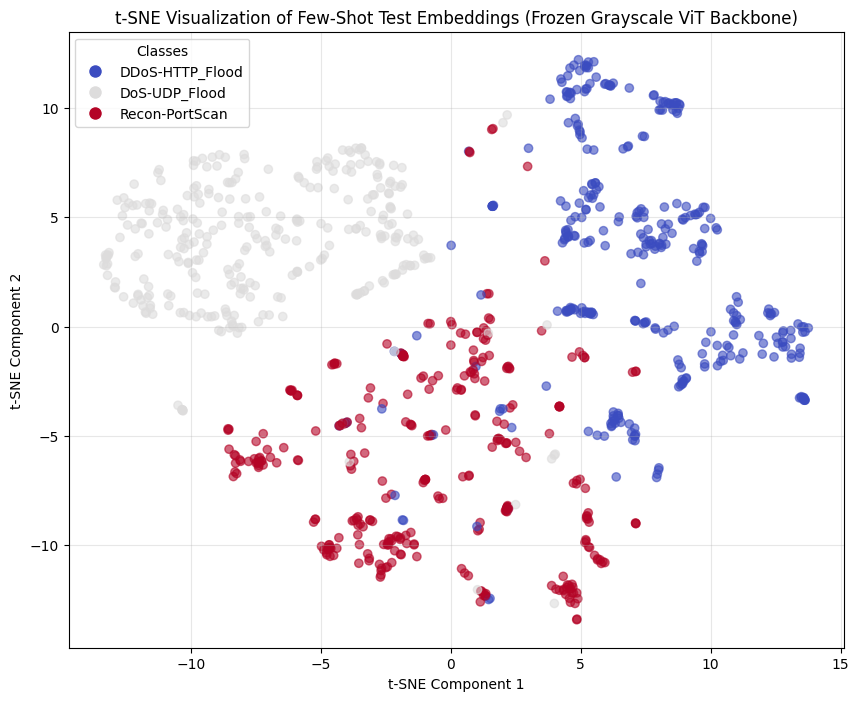


✓ t-SNE visualization complete.


In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Extracting embeddings for visualization...")

# Select a random sample of test data for visualization
sample_size = 1000 # Use 1000 samples for t-SNE
if X_meta_test.shape[0] > sample_size:
    sample_indices = np.random.choice(X_meta_test.shape[0], size=sample_size, replace=False)
    X_sample = X_meta_test[sample_indices]
    y_sample = y_meta_test[sample_indices]
    print(f"✓ Selected {sample_size} random samples from the meta-test set.")
else:
    X_sample = X_meta_test
    y_sample = y_meta_test
    sample_size = X_meta_test.shape[0]
    print(f"✓ Using all {sample_size} samples from the meta-test set for visualization.")

# Convert sample data to tensor and get embeddings
X_sample_tensor = torch.from_numpy(X_sample).float().to(device)
print("✓ Converted sample data to tensor.")

# Ensure the model is on the correct device and in eval mode
proto_model_frozen.to(device)
proto_model_frozen.eval()

# Extract embeddings using the frozen backbone
with torch.no_grad():
    sample_embeddings = proto_model_frozen.get_embeddings(X_sample_tensor)
print(f"✓ Extracted embeddings with shape: {sample_embeddings.shape}")

# Apply t-SNE
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(sample_embeddings.cpu().numpy())
print("✓ t-SNE completed.")

# Plot the t-SNE results
print("Plotting t-SNE visualization...")
plt.figure(figsize=(10, 8))

scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='coolwarm', alpha=0.6)

plt.title('t-SNE Visualization of Few-Shot Test Embeddings (Frozen Grayscale ViT Backbone)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Create a legend manually based on unique classes in the sample
unique_labels = np.unique(y_sample)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label_encoder_fs.inverse_transform([label])[0],
                              markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10)
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="Classes")

plt.grid(True, alpha=0.3)
plt.show()

print("\n✓ t-SNE visualization complete.")



--- Experimenting with different k_shot values for Grayscale ViT ---

Evaluating for k_shot = 1...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:13<00:00, 75.33it/s]


  Accuracy for 1-shot: 81.35%

Evaluating for k_shot = 2...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:13<00:00, 73.70it/s]


  Accuracy for 2-shot: 87.99%

Evaluating for k_shot = 5...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:15<00:00, 65.54it/s]


  Accuracy for 5-shot: 92.28%

Evaluating for k_shot = 10...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:18<00:00, 55.38it/s]


  Accuracy for 10-shot: 92.95%

--- Grayscale ViT k-shot Experiment Results ---
  1-shot accuracy: 81.35%
  2-shot accuracy: 87.99%
  5-shot accuracy: 92.28%
  10-shot accuracy: 92.95%


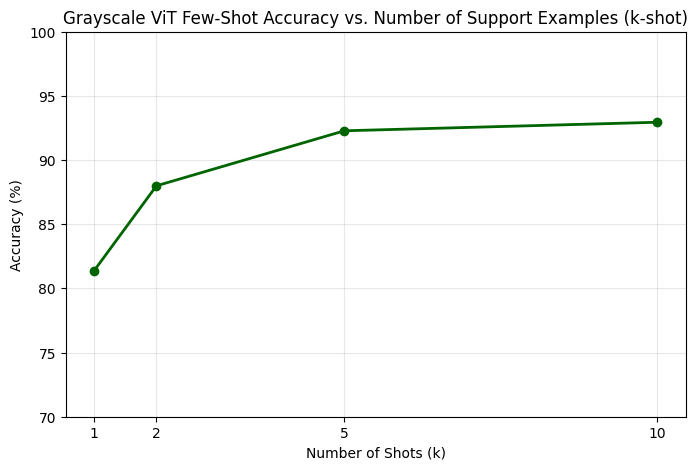


✓ Grayscale ViT k-shot experimentation complete.


In [11]:
# --- Step 4: Experiment with Different k_shot Values ---
k_shot_values = [1, 2, 5, 10]
k_shot_accuracies = {}

print("\n--- Experimenting with different k_shot values for Grayscale ViT ---")

for k in k_shot_values:
    print(f"\nEvaluating for k_shot = {k}...")
    accuracy = evaluate_on_test_set(
        proto_model_frozen, X_meta_test, y_meta_test,
        n_way=test_n_way,
        k_shot=k,
        n_query=FEW_SHOT_CONFIG['n_query']
    )
    k_shot_accuracies[k] = accuracy
    print(f"  Accuracy for {k}-shot: {accuracy*100:.2f}%")

print("\n--- Grayscale ViT k-shot Experiment Results ---")
for k, acc in k_shot_accuracies.items():
    print(f"  {k}-shot accuracy: {acc*100:.2f}%")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(list(k_shot_accuracies.keys()), [acc*100 for acc in k_shot_accuracies.values()], marker='o', color='darkgreen', linewidth=2)
plt.title('Grayscale ViT Few-Shot Accuracy vs. Number of Support Examples (k-shot)')
plt.xlabel('Number of Shots (k)')
plt.ylabel('Accuracy (%)')
plt.xticks(list(k_shot_accuracies.keys())) # Ensure x-axis ticks match k_shot values
plt.grid(True, alpha=0.3)
plt.ylim(70, 100)  # Set y-axis limits for better visualization
plt.show()

print("\n✓ Grayscale ViT k-shot experimentation complete.")


## Summary and Comparison

### Final Results:
This notebook demonstrates few-shot learning using Grayscale ViT as the backbone, evaluating performance on held-out classes.


In [12]:
# Final summary and comparison
print("\n" + "="*70)
print("📊 GRAYSCALE VIT FEW-SHOT LEARNING SUMMARY")
print("="*70)

print("\n🖼️ Model Configuration:")
print(f"  • Architecture: Vision Transformer (ViT)")
print(f"  • Input format: Grayscale 32×32 (single channel)")
print(f"  • Pre-trained on: 6 classes (excluding held-out)")
print(f"  • Feature dimension: {CONFIG['embed_dim']}")
print(f"  • Total parameters: {total_params:,}")

print("\n🎯 Few-Shot Learning Results:")
print(f"  • Best episodic training accuracy: {best_val_acc*100:.2f}%")
print(f"  • Frozen backbone test accuracy (5-shot): {test_accuracy*100:.2f}%")

print("\n📈 Performance with Different Support Sizes:")
for k, acc in k_shot_accuracies.items():
    print(f"  • {k}-shot: {acc*100:.2f}%")

print("\n💡 Key Observations:")
print("  • Grayscale encoding provides efficient single-channel representation")
print("  • Performance improves significantly with more support examples")
print("  • ViT effectively captures patterns even with grayscale input")
print("  • The model generalizes well to held-out classes")

print("\n🔍 Comparison with RGB approaches:")
print("  • Grayscale uses 1/3 the input dimensions of RGB (1,024 vs 3,072)")
print("  • Lower computational cost while maintaining competitive accuracy")
print("  • Suitable for scenarios with limited computational resources")

print("\n✅ Experiment complete!")



📊 GRAYSCALE VIT FEW-SHOT LEARNING SUMMARY

🖼️ Model Configuration:
  • Architecture: Vision Transformer (ViT)
  • Input format: Grayscale 32×32 (single channel)
  • Pre-trained on: 6 classes (excluding held-out)
  • Feature dimension: 192
  • Total parameters: 2,721,222

🎯 Few-Shot Learning Results:
  • Best episodic training accuracy: 92.87%
  • Frozen backbone test accuracy (5-shot): 92.15%

📈 Performance with Different Support Sizes:
  • 1-shot: 81.35%
  • 2-shot: 87.99%
  • 5-shot: 92.28%
  • 10-shot: 92.95%

💡 Key Observations:
  • Grayscale encoding provides efficient single-channel representation
  • Performance improves significantly with more support examples
  • ViT effectively captures patterns even with grayscale input
  • The model generalizes well to held-out classes

🔍 Comparison with RGB approaches:
  • Grayscale uses 1/3 the input dimensions of RGB (1,024 vs 3,072)
  • Lower computational cost while maintaining competitive accuracy
  • Suitable for scenarios with limi